# Predicting In-Game Win Probability

The purpose of this model is to predict the in-game win probability for the home team, based on the current game state. The model takes the goal and shot totals for each team, as well as the current game time. It outputs an estimated probability of the home team winning. Team strength and style effects will be included later. 

These results will be used as an input to the Player Impact model, where player contributions occurring when the game is still in the balance (i.e. the in-game win probability is closer to 50%) are weighted more heavily than contributions when the outcome of a game is more certain. 

The model is kept intentionally simple, ignoring game events such as hits and penalties. However, the requirement of an output probability limits the selection of possible model classes. In this investigation, three classes are trained and compared:
1. Logistic Regression
2. Naive Bayes
3. Neural Network

It should be noted that both Logistic Regression and Naive Bayes require independence of features. While goals and game time are nearly independent (goals are almost equally likely to be scored at any moment of the game), this is less clear for goals and shots. If a team directs more shots on net, they have a better chance of scoring a goal. However, the pairplot below indicates only a weak correlation between goals and shots, so I will assume they are independent for the purpose of this model selection process.

It's a fairly simply problem, so all three models performed similarly. They all scored better than the trivial fit and are relatively well calibrated. However, the neural network is the only one that takes game time into account, and it is the best calibrated. Additionally, the idea of the model is relatively simple, and the results are intuitive, so interpretability is not a concern. Therefore, the neural network is the model chosen to move forward with. For the working version, an ensemble of models will be trained and used to predict the in-game win probability, as this smooths out initialization and training differences.

### TODO
- Describe the assumptions of the model classes and why the model classes work


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.stats import kurtosis
from common import create_db_connection, select_table
from nhl_api.ref_common import game_time_to_sec
from models.common_torch import RegressionNN, CustomDataset, train_loop


In [2]:
# Create the database connection
connection = create_db_connection('postgres', 'marshineer', 'localhost', '5432',
                                  'password')


In [3]:
def plot_calibration_curves(models, preds, ys, names=None, figsize=(8, 5), n_bins=10,
                            class1='Class 1'):
    """ Plots calibration curves for a probabilistic binary classifier
    
    Reference: https://scikit-learn.org/stable/modules/calibration.html
    
    The function takes a list of models and their predictions and plots the
    calibration curve. This curve indicates whether the model is predicting class
    probabilities with a frequency proportional to the true fraction of that 
    class in the probability bin. For example, it should predict class 1 with a 
    probability of 80% correctly 80% of the time. Note: the calibration may be 
    affected by sample size, for probability bins with few predictions.
    
    The prediction count distribution is plotted on a second axes, to allow
    visual identification of whether poor calibration corresponds to bins with
    few samples.
    
    Parameters
        models: list = models for which to plot calibration curve
        preds: list = test data predictions for each model
        ys: list = test data ground truths
        names: list = the model names, for plotting the legend
        figsize: tuple = the (width, height) size of the matplotlib figure
        n_bins: int = the number of probability bins used for calibration
        class1: str = the name of class 1, for plotting
    
    Returns
        fig: matplotlib figure
        ax: matplotlib axes = the true class 1 fraction (i.e. calibration)
        ax2: matplotlib axes = the prediction distribution
    """
    
    # Set generic names, if none provided
    if names is None:
        names = [f'Model {i + 1}' for i in range(len(models))]

    # Initialize the plot and create the names (if none given)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax2 = ax.twinx()
    
    for i, (model, y_pred, y_true, name) in enumerate(zip(models, preds, ys, names)):
        # Calculate the calibration curve data
        counts, bins = np.histogram(y_pred, bins=n_bins)
        mean_pred = np.zeros(bins.size - 1)
        true_frac = np.zeros(bins.size - 1)
        for j in range(bins.size - 1):
            bin_mask = (y_pred >= bins[j]) & (y_pred < bins[j + 1])
            y_pred_bin = y_pred[bin_mask]
            mean_pred[j] = np.mean(y_pred_bin)
            y_true_bin = y_true[bin_mask]
            true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size

        # Plot the calibration curve
        ax.plot(mean_pred, true_frac, c=f'C{i}', marker='s', label=name)

        # Plot the prediction distributions for comparison
        xs = bins[:-1] + np.diff(bins)[0] / 2
        if len(models) == 1:
            ax2.bar(xs, counts, color='C1', width=1 / bins.size, alpha=0.4)
        else:
            ax2.hist(y_pred, bins=bins, color=f'C{i}', histtype='step')

        # Print the RMSE for each calibration curve
        wtd_rmse = np.sqrt(np.nanmean(((mean_pred - true_frac) ** 2) * counts))
        print(f"The calibration RMSE for the {name} model (weighted by bin counts) is {wtd_rmse:4.3f}")

    # Plot the ideal calibration curve
    ax.plot([0, 1], [0, 1], 'k--', label='Ideal Calibration')
    
    # Set plot attributes
    ax.set_xlabel(f"Mean Predicted Probability of '{class1}' in Bin", fontsize=12)
    ax.set_ylabel(f"Actual Fraction of '{class1}' in Bin", fontsize=12)
    # ax.set_title('Calibration Curves', fontsize=16)
    if len(models) <= 5:
        ax.legend()
    else:
        ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02))
    ax2.set_ylabel(f"Count of '{class1}' in Bin", fontsize=12);
    
    return fig, ax, ax2


def plot_in_game_probs(shots_df, home_win, team_names, x_scalers, models,
                       game_len=3600, names=None, figsize=(8, 5)):
    """ Plots in-game win probability predictions as function of game time
    
    The probability of a home win is predicted using the game state at each 
    second of a game. The game state include the model inputs: goal differential,
    shot differential and game time. 
    
    Ideally, late-game events have a stronger effect on predicted probability
    than early-game events, the game time will have a drift effect, and goals
    will cause jumps in the probability. The probability in the last second of
    the game should always be 1 or 0.
    
    Parameters
        shots_df: dataframe = all shots for the game
        home_win: bool = indicates whether home team wins
        team_names: list = team names ['home team', 'away team']
        x_scalers: list = scalers fit to the training data
        models: list = models for which to plot calibration curve
        game_len: int = length of the game (seconds)
        names: list = the model names, for plotting the legend
        figsize: tuple = the (width, height) size of the matplotlib figure
    """
    
    # Set generic names, if none provided
    if names is None:
        names = [f'Model {i + 1}' for i in range(len(models))]
    
    # Generate a list of inputs
    shot_list = shots_df.to_dict('records')
    input_arr = np.zeros((game_len, 3))
    home_shots = 0
    away_shots = 0
    home_score = 0
    away_score = 0
    shot_cnt = 0
    shot = shot_list[shot_cnt]
    period = shot['period']
    period_time = shot['period_time']
    shot_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    goal_list = []
    for sec in range(game_len):
        # Set the game state (model input)
        # input_list = [home_score - away_score, home_shots - away_shots, sec]
        input_list = [home_score - away_score, home_shots - away_shots, 3600 - sec]
        input_arr[sec, :] = input_list

        # If a shot occurred at this time, update the game state
        if sec == shot_time:
            # Set the game state values
            if shot['shooter_home']:
                home_shots += 1
            else:
                away_shots += 1
            home_score = shot['home_score']
            away_score = shot['away_score']

            # If the shot was a goal, add to plot list
            if shot['shot_result'] == 'GOAL':
                score1 = home_score if home_win else away_score
                score2 = away_score if home_win else home_score
                goal_list.append([shot_time, shot['shooter_home'], f'{score1}-{score2}'])

            # Get the next shot
            shot_cnt += 1
            if shot_cnt < len(shot_list):
                shot = shot_list[shot_cnt]
            period = shot['period']
            period_time = shot['period_time']
            shot_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)

    # Scale the inputs and make predictions
    in_game_probs = np.zeros((game_len, len(models)))
    for i, model in enumerate(models):
        x_scaler = x_scalers[i]
        if model.get('type') == 'NN':
            if model['model'].input_dim == 2:
                input_arr = np.delete(input_arr, 1, axis=1)
            input_arr_scaled = x_scaler.transform(input_arr)
            in_game_probs[:, i] = sigmoid(model['model'](Tensor(input_arr_scaled))).detach().numpy().squeeze()
        else:
            input_arr_scaled = x_scaler.transform(input_arr)
            in_game_probs[:, i] = model['model'].predict_proba(input_arr_scaled)[:, 1]

    # Plot the in-game 'home win' probabilities
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i in range(len(models)):
        ax.plot(np.arange(game_len), in_game_probs[:, i], f'C{i}', label=names[i])

    # Plot the goal times
    prev_t = -220
    prev_home = None
    for t_goal, home_goal, score in goal_list:
        ax.vlines(t_goal, 0, 1, 'k', '--', linewidth=0.5)
        if home_goal:
            height = 0.95
            if (t_goal - prev_t) < 220 and prev_home == home_goal:
                height += 0.035
        else:
            height = 0.05
            if (t_goal - prev_t) < 220 and prev_home == home_goal:
                height -= 0.035
        ax.text(t_goal, height, score, fontsize=10, ha='left', va='center')
        prev_t = t_goal
        prev_home = home_goal

    # Set plot attributes
    ax.set_xlabel('Game Time (seconds)', fontsize=12)
    ax.set_ylabel(f'Probability of {team_names[0]} Win', fontsize=12)
    ax.set_ylim([0, 1])
    w_team = team_names[0] if home_win else team_names[1]
    score1 = home_score if home_win else away_score
    score2 = away_score if home_win else home_score
    ttl_str1 = f'{team_names[1]} at {team_names[0]}\n'
    ttl_str2 = f'Final score {score1}-{score2} {w_team}'
    ax.set_title(ttl_str1 + ttl_str2, fontsize=16)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.03));

    return fig, ax


def calc_game_length(game_shots, game_data):
    """ Calculate the length of a particular game
    
    Parameters
        game_shots: list of dicts = all shots and goals in the game
        game_data: dict = game summary data
        
    Returns
        game_length: int = length of game in seconds
    """
    
    if game_data['number_periods'] == 3:
        return 3600
    elif game_data['shootout']:
        return 3900
    else:
        last_shot = game_shots[-1]
        if last_shot['shot_result'] == 'GOAL':
            period = last_shot['period']
            period_time = last_shot['period_time']
            return (period - 1) * 20 * 60 + game_time_to_sec(period_time)
        elif last_shot['last_event_type'] == 'GOAL':
            last_shot = game_shots[-2]
            period = last_shot['period']
            period_time = last_shot['period_time']
            return (period - 1) * 20 * 60 + game_time_to_sec(period_time)
        elif game_shots[-2]['last_event_type'] == 'GOAL':
            last_shot = game_shots[-2]
            period = last_shot['period']
            period_time = last_shot['period_time']
            return (period - 1) * 20 * 60 + game_time_to_sec(period_time)
        else:
            print(last_shot)
            print()


## Preprocessing and Model Inputs

There is very little preprocessing required, as much of this has been done previously. Misses and blocked shots are ignored, as these are thought to have less of an impact on the game status. 

Playoff games are removed as they are biased by including only the best teams in the league, and because long overtime games create problems when the data is normalized. Overtime shots in the regular season are also removed for similar reasons. The best players receive the vast majority of ice time in OT, thereby biasing the model. Additionally, including overtime affects how the models use the game time feature. Since all features are normalized, it is no longer clear when the end of the game is, when overtime shots are included. 

Leaving OT shots in was shown to bias the model away from a conclusive prediction at the game time limit (the predicted win probability for teams with a one goal lead in the last second of play were only 90%). Since the model is meant to determine whether a game outcome is still to be determined, it makes sense that the model predicts nearly 100% probability for any lead with no time remaining in the game. One unintended effect of removing overtime games is that the model behaves a little erratically for tied scores late in games. Hopefully this will be smoothed out by using an ensemble in the final version. It also means that a separate model will be required if I wish to evaluate the game state in overtime.

The model inputs are reduced to three features:
1. Score Difference = Home Score - Away Score
2. Shot Difference = Home Shots - Away Shots
3. Game Time (in seconds)

The target variable is a binary variable ($y \in [0, 1]$), where a 1 indicates the home team wins.


In [4]:
# Load the game and shot data
# games_df = pd.read_csv('~/Hockey-Analytics/data/games.csv')
games_df = select_table(connection, 'games')
games_list = games_df.to_dict('records')
games = {game_x['game_id']: game_x for game_x in games_list}

# shots_df = pd.read_csv('~/Hockey-Analytics/data/shots.csv')
shots_df = select_table(connection, 'shots')
shots_df = shots_df.loc[shots_df.shot_result.isin(['GOAL', 'SHOT'])]
print(shots_df.columns.tolist())


['game_id', 'shot_id', 'shooter_id', 'shot_type', 'shot_result', 'period', 'period_time', 'home_team_id', 'away_team_id', 'home_score', 'away_score', 'x_coord', 'y_coord', 'net_distance', 'net_angle', 'rebound_shot', 'last_event_type', 'time_since_last', 'last_x_coord', 'last_y_coord', 'delta_y', 'angle_change', 'play_ends', 'puck_frozen', 'goal', 'missed', 'blocked', 'empty_net', 'shooter_home', 'shooter_hand', 'off_wing_shot', 'players_home', 'players_away']


In [5]:
# Remove select data from dataset
print('Removed:')

# Remove empty net goals
print(f'Number of goals on empty nets = {len(shots_df[shots_df.empty_net == True])} '
      f'({100 * len(shots_df[shots_df.empty_net == True]) / len(shots_df[shots_df.shot_result == "GOAL"]):4.2f}% of all goals)')
shots_df.drop(shots_df[shots_df.empty_net == True].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Remove overtime games
overtime_games = games_df.loc[games_df.number_periods > 3]
print(f'Number of overtime games = {len(overtime_games)} '
      f'({100 * len(overtime_games) / len(games_df):4.2f}% of all games)')
shots_df.drop(shots_df[shots_df.game_id.isin(overtime_games.game_id.tolist())].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# # Remove overtime shots
# print(f'Number of shots in overtime = {len(shots_df[shots_df.period > 3])} '
#       f'({100 * len(shots_df[shots_df.period > 3]) / len(shots_df):4.2f}% of all shots)')
# shots_df.drop(shots_df[shots_df.period > 3].index, inplace=True)
# shots_df.reset_index(drop=True, inplace=True)

# # Remove shootout games
# shootout_games = games_df.loc[games_df.shootout]
# print(f'Number of shootout games = {len(shootout_games)} '
#       f'({100 * len(shootout_games) / len(games_df):4.2f}% of all games)')
# shots_df.drop(shots_df[shots_df.game_id.isin(shootout_games.game_id.tolist())].index, inplace=True)
# shots_df.reset_index(drop=True, inplace=True)

# Remove playoff games
playoff_games = games_df.loc[games_df.type == 'PLA']
print(f'Number of playoff games = {len(playoff_games)} '
      f'({100 * len(playoff_games) / len(games_df):4.2f}% of all games)')
shots_df.drop(shots_df[shots_df.game_id.isin(playoff_games.game_id.tolist())].index, inplace=True)
shots_df.reset_index(drop=True, inplace=True)

# Convert the shots to a list
shots_list = shots_df.to_dict('records')


Removed:
Number of goals on empty nets = 3880 (4.64% of all goals)
Number of overtime games = 3491 (23.34% of all games)
Number of playoff games = 1051 (7.03% of all games)


In [6]:
# Define the input features and target variable
data_cols = ['goal_diff', 'shot_diff', 'game_time', 'home_win']  # Add team strengths later
data_cols_gameid = ['game_id', 'goal_diff', 'shot_diff', 'game_time', 'home_win']  # Add team strengths later
this_game_id = None
home_shots = None
away_shots = None
home_win = None
data_list = []
data_list_gameid = []
n_games = 0
n_home_wins = 0
for shot in shots_list:
    game_id = shot['game_id']
    if this_game_id != game_id:
        game_data = games[game_id]
        # game_shots = shots_df[shots_df.game_id == game_id].to_dict('records')
        # game_len = calc_game_length(game_shots, game_data)
        game_len = 3600
        # if n_games > 0:
        #     # data_list.append([home_score - away_score, home_shots - away_shots, game_len, home_win])
        #     data_list.append([home_score - away_score, home_shots - away_shots, 0, home_win])
        this_game_id = game_id
        home_shots = 1
        away_shots = 1
        home_win = 1 if game_data['home_win'] else 0
        if home_win == 1:
            n_home_wins += 1
        n_games += 1
        # # data_list.append([0, 0, 0, home_win])
        # data_list.append([0, 0, game_len, home_win])
        if shot['shooter_home']:
            home_shots = 1
            away_shots = 0
        else:
            home_shots = 0
            away_shots = 1
    else:
        if shot['shooter_home']:
            home_shots += 1
        else:
            away_shots += 1
    period = shot['period']
    period_time = shot['period_time']
    # game_time = (period - 1) * 20 * 60 + game_time_to_sec(period_time)
    game_time = game_len - ((period - 1) * 20 * 60 + game_time_to_sec(period_time))
    home_score = shot['home_score']
    away_score = shot['away_score']
    data_list.append([home_score - away_score, home_shots - away_shots, game_time, home_win])
    data_list_gameid.append([game_id, home_score - away_score, home_shots - away_shots, game_time, home_win])
    
data_df = pd.DataFrame(data_list, columns=data_cols)
data_df_gameid = pd.DataFrame(data_list_gameid, columns=data_cols_gameid)


## Input Visualization

The plots below were created as a sanity check, and to determine what preprocessing needed to be done. This contributed to deciding to remove the overtime shots and empty net goals. Additionally, the following observations are noted.
- The shot events are distributed approximated evenly across game times
- Both shot and goal differentials have a kurtosis > 0 (the peaky shape), meaning there is a slightly greater number of outliers compared to a normal distribution
- There are no strong monotonic correlations between the features and target (goal differential shows a moderate correlation)
- The proportion of shot events corresponding to home wins is approximately equal to the actual proportion of home wins

These results generally match what I would expect, although I would have thought the shot and goal differentials would follow almost a pefectly normal distribution. 

Since the goal differential is the only feature correlated with the target variable, it may be possible to simplify the model by training on this single feature. This will be invesitgated later. 

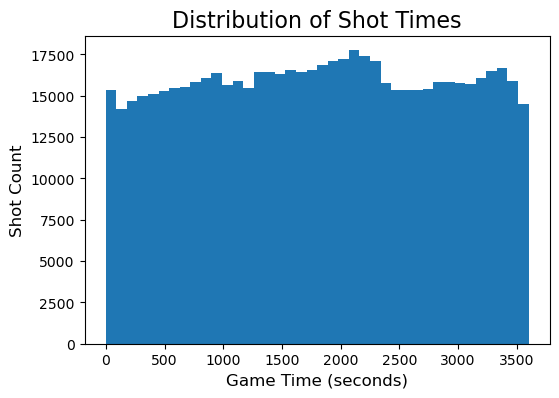

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(data_df.game_time, bins=40)
ax.set_title('Distribution of Shot Times', fontsize=16)
ax.set_xlabel('Game Time (seconds)', fontsize=12)
ax.set_ylabel('Shot Count', fontsize=12);


The kurtosis of goal_diff is 0.89
The kurtosis of goal_diff is 1.12


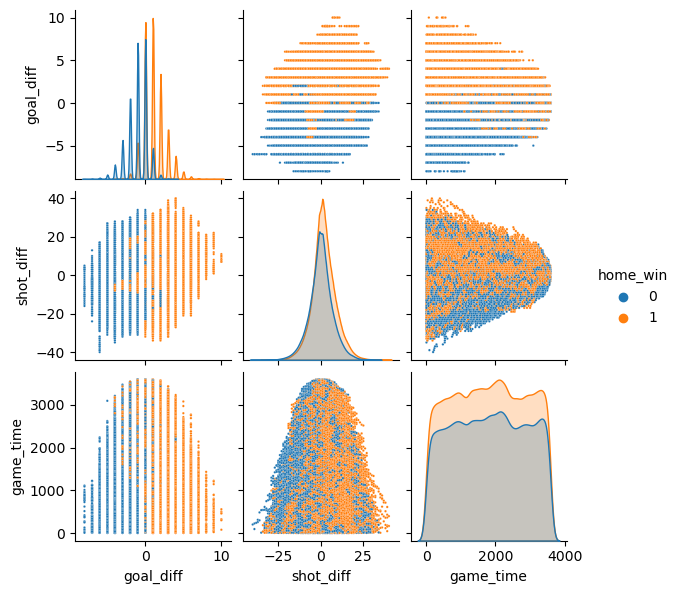

In [8]:
# Display the feature relationships in scatter plots
# sns.pairplot(data_df.iloc[:, :-1], height=2, diag_kind='kde')
sns.pairplot(data_df, height=2, diag_kind='kde', hue='home_win', plot_kws={"s": 3})
print(f'The kurtosis of goal_diff is {kurtosis(data_df.goal_diff, bias=False):3.2f}')
print(f'The kurtosis of goal_diff is {kurtosis(data_df.shot_diff, bias=False):3.2f}')


In [9]:
# late_shots = data_df.loc[(data_df.game_time > 3570) & (data_df.goal_diff == 1)]
late_shots = data_df.loc[(data_df.game_time < 30) & (data_df.goal_diff == 1)]
p_late_win = len(late_shots.loc[late_shots.home_win == 1]) / len(late_shots)
print(len(late_shots))
# display(late_shots.head(n=20))
display(p_late_win)

errors = data_df_gameid.loc[(data_df_gameid.game_time > 2000) & (data_df_gameid.goal_diff > 5) & (data_df_gameid.home_win == 0)]
# errors = data_df.loc[(data_df.goal_diff > 0) & (data_df.home_win == 0)]
print(len(errors))
# display(games[2021021050])
# display(games[2021021300])
# display(errors.tail(n=40))


1105


1.0

0


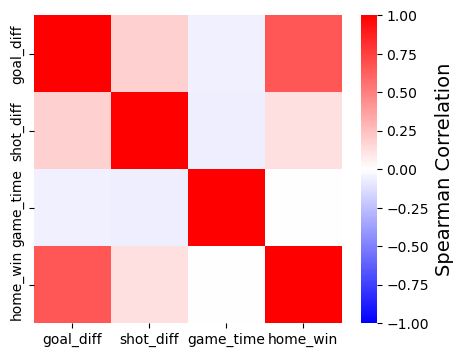

In [10]:
# Plot Feature Correlations
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.heatmap(data_df.corr(method='spearman'), cmap='bwr', vmin=-1, vmax=1, square=True, ax=ax)
ax.collections[0].colorbar.set_label('Spearman Correlation', fontsize=14)


Home team winning corresponds to 55.48% of data points
Home team wins 55.04% of games


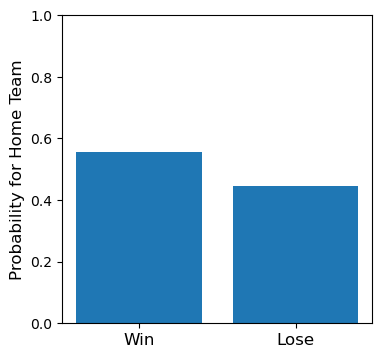

In [11]:
# Plot the distribution of home wins
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
win_mask = data_df.home_win == 1
targets = [len(data_df.home_win.loc[win_mask]) / len(data_df),
           len(data_df.home_win.loc[~win_mask]) / len(data_df)]
ax.bar([0.5, 1.5], targets)
ax.set_ylabel('Probability for Home Team', fontsize=12)
ax.set_ylim([0, 1])
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Win', 'Lose'], fontsize=12)

# Calculate the "trivial" logloss
p_home_win = len(data_df.home_win.loc[win_mask]) / len(data_df)
trivial_logloss = -(p_home_win * np.log(p_home_win) + (1 - p_home_win) * np.log(1 - p_home_win))
print(f'Home team winning corresponds to {100 * p_home_win:4.2f}% of data points')
print(f'Home team wins {100 * (n_home_wins / n_games):4.2f}% of games')


## Model Selection

Firstly, the data is split into training and test sets, as well as being normalized to the range [0, 1]. Following best practices, the test data is normalized using the fit of the training data. Note that since the data set is quite large, random shuffling results in approximately similar class distributions in both the training and test sets.

Three model classes are trained and compared.
1. Logistic Regressor
2. Naive Bayes Classifier
3. Neural Network

Sklearn has a built-in logistic regressor and naive Bayes classifier. These include an attribute that predicts the probability of a class directly. The neural network is programmed using PyTorch, with a logit function applied to the output to transform the predictions into probabilities.

Although the data is not entirely Gaussian, the GaussianNB model seemed the best fit for the problem. There are few parameters to tune for this model, so the base version was used. The LogisticRegression model has a greater selection of model parameters, but it trains quickly, so a grid search was done to find the best combination of regularization and solver. The cross-validation splits are done using a stratified k-fold, to ensure the balance of target classes remains consistent during the parameter search. 

The neural network is a simple, 3-layer network. Multiple learning rates and, batch sizes, and optimizers (stochastic gradient descent (SGD) and Adam) were tested. None of the selections had a significant impact on the performance, but the Adam solver trained much faster than SGD. Therefore, the Adam solver with a learning rate of $10^{2}$ was used.


In [12]:
# Split the data into training and test sets
X_pd, y_pd = data_df.iloc[:, :-1].values, data_df.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.25, random_state=66)
X_train, X_test, y_train, y_test = tmp_split

# Scale the data
x_scaler = MinMaxScaler()
X_train_norm = x_scaler.fit_transform(X_train)
X_test_norm = x_scaler.transform(X_test)


In [13]:
# Logistic regression model
# https://medium.com/towards-data-science/assumptions-of-logistic-regression-clearly-explained-44d85a22b290
d_logr = {'name': 'Logistic Regression',
          'model': LogisticRegression(max_iter=500, penalty='l2', class_weight='balanced'),
          'params': {'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [1, 10, 50, 100, 200, 500, 1000]}}


In [14]:
# Train the model using k-fold cross-validation and a random parameter search
t_start = time()
cv_split = StratifiedKFold(n_splits=10)
param_search = GridSearchCV(d_logr['model'], d_logr['params'], scoring='neg_log_loss', n_jobs=-1, cv=cv_split)
param_search.fit(X_train_norm, y_train)
d_logr['search_result'] = param_search
d_logr['model'] = param_search.best_estimator_
d_logr['train_loss'] = -param_search.best_score_
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the logistic regressor')


Took 0:01:19.659213 to train the logistic regressor


Trivial logloss for this problem: 0.687
Training logloss on Logit model: 0.422
Test logloss on Logit model: 0.424
Test accuracy on Logit model: 76.72%


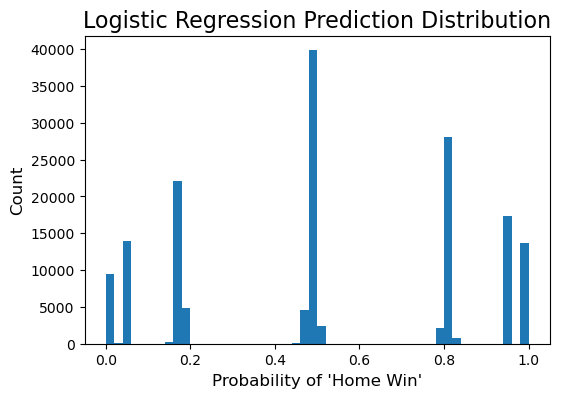

In [15]:
# Make predictions on the test set
d_logr['y_pred'] = d_logr['model'].predict_proba(X_test_norm)[:, 1]
d_logr['test_loss'] = log_loss(y_test, d_logr['y_pred'])
pred_classes = np.round(d_logr['y_pred'], 0)
d_logr['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_logr['y_pred'], bins=50);
ax.set_title('Logistic Regression Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on Logit model: {d_logr['train_loss']:4.3f}")
print(f"Test logloss on Logit model: {d_logr['test_loss']:4.3f}")
print(f"Test accuracy on Logit model: {d_logr['test_acc']:4.2f}%")


In [16]:
# Naive Bayes model
# https://scikit-learn.org/stable/modules/naive_bayes.html#
t_start = time()
d_nbayes = {'name': 'Naive Bayes',
            'model': GaussianNB()}
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the naive bayes model')


Took 0:00:00.000063 to train the naive bayes model


Trivial logloss for this problem: 0.687
Training logloss on NB model: 0.428
Test logloss on NB model: 0.429
Test accuracy on NB model: 78.38%


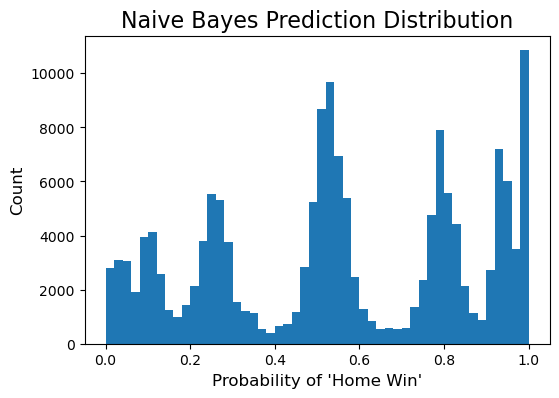

In [17]:
# Train and test the model
d_nbayes['model'].fit(X_train_norm, y_train)
d_nbayes['train_loss'] = log_loss(y_train,
                                  d_nbayes['model'].predict_proba(X_train_norm)[:, 1])
d_nbayes['y_pred'] = d_nbayes['model'].predict_proba(X_test_norm)[:, 1]
d_nbayes['test_loss'] = log_loss(y_test, d_nbayes['y_pred'])
pred_classes = np.round(d_nbayes['y_pred'], 0)
d_nbayes['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nbayes['y_pred'], bins=50);
ax.set_title('Naive Bayes Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);

print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on NB model: {d_nbayes['train_loss']:4.3f}")
print(f"Test logloss on NB model: {d_nbayes['test_loss']:4.3f}")
print(f"Test accuracy on NB model: {d_nbayes['test_acc']:4.2f}%")


In [37]:
import torch.nn as nn
from torch import optim, Tensor, sigmoid
from torch.utils.data import DataLoader


In [49]:
# Define hyperparameters
learning_rate = 1e-4
batch_size = 512
n_epochs = 100
loss_fn = nn.BCEWithLogitsLoss()


In [50]:
# Define the training and test data loaders
train_data = CustomDataset(X_train_norm, y_train)
test_data = CustomDataset(X_test_norm, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
d_nn = {'name': 'Neural Network',
        'model': RegressionNN(X_train_norm.shape[-1], 32, 1).to('cpu').float(),
        'type': 'NN'}
# optimizer = optim.SGD(d_nn['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn['model'].parameters(), lr=learning_rate)


Took 0:06:42.640166 to train the model


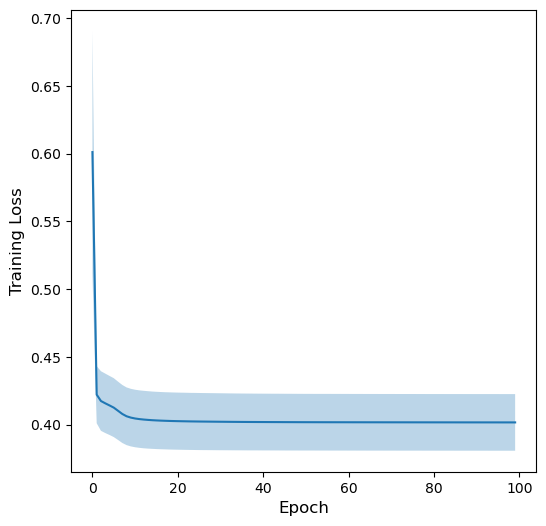

In [51]:
# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader, d_nn['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the model')
plt.show()


Trivial logloss for this problem: 0.687
Training logloss on NN model: 0.402
Test logloss on NN model: 0.403
Test accuracy on NN model: 78.46%


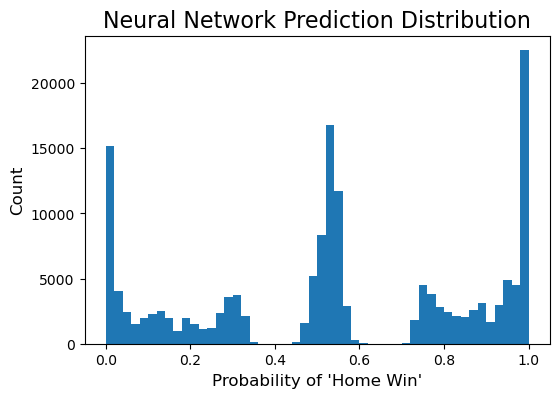

In [52]:
# Test the model
y_pred_train_nn = sigmoid(d_nn['model'](Tensor(X_train_norm))).detach().numpy().squeeze()
d_nn['train_loss'] = log_loss(y_train, y_pred_train_nn, eps=1e-7)
d_nn['y_pred'] = sigmoid(d_nn['model'](Tensor(X_test_norm))).detach().numpy().squeeze()
d_nn['test_loss'] = log_loss(y_test, d_nn['y_pred'], eps=1e-7)
print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on NN model: {d_nn['train_loss']:4.3f}")
print(f"Test logloss on NN model: {d_nn['test_loss']:4.3f}")
pred_classes = np.round(d_nn['y_pred'], 0)
d_nn['test_acc'] = 100 * (pred_classes == y_test).sum() / y_test.size
print(f"Test accuracy on NN model: {d_nn['test_acc']:4.2f}%")

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn['y_pred'], bins=50)
ax.set_title('Neural Network Prediction Distribution', fontsize=16)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


## Model Comparison

The three models are compared by the following methods:
- Logloss performance
- Accuracy
- Prediction calibration
- Confusion matrices
- Qualitative assessment

### Logloss performance: 
This is the most common evaluator for binary class probability predictions. There are numerous resources online describing the utility of logloss for this application, so I won't go into it here. Each of the models performed similarly, and they all performed better than the trivial loss of $L(p)=0.688$. Note: the trivial loss is calculated as $p \cdot ln(p) + (1-p)\cdot ln(1-p)$, where N is the number of target classes and p is the probability of the target class equalling either 0 or 1.

### Accuracy:
Since the dataset is well balanced (approximately 55-45), accuracy is a reasonable metric to use. If the classes were more imbalanced, the F1 score could be calculated. Again, the models all performed similarly, at an accuracy just below 75%.

### Prediction calibration:
This metric is described in further detail in sklearn's [documentation](https://scikit-learn.org/stable/modules/calibration.html). The main idea is that data points classified with a certain probability, should be correctly classified at the rate of the probability. For example, if the model predicts 100 data points as class 1, with a probability of 80%, then 80 of those points should actually belong to class 1, while the other 20 should belong to class 0. These proportions will hold for all probabilities in a well calibrated model. The idea behind this is intuitive. Data points that are difficult to classify (i.e. with a prediction probability near 50%) should be incorrectly classified less often than points given a 95% probability.

In practice, this is calculated statistically, by binning predictions and comparing the bin probabilities with the true fraction of classes. Note that if a bin includes zero data points, the fraction of correctly classified points will evaluate to nan. This is the cause for the warnings in this section.

This can be assessed qualitatively, with a calibration curve. As described above, an ideal model will lie along the diagonal line. Sub-optimal models will deviate from this diagonal. This deviation is a residual, so I decided to quantify the performance using the root mean squared error (RMSE). I noticed that many of the deviations coincided with bins containing few samples, so I weighted by bin counts to account for sample size. This provided a quantitative measure by which to compare the models' calibration.

### Confusion matrices:
There is not much to separate the models here, but it is interesting to note that both the naive Bayes and neural network models tend to overpredict home wins, while the logistic regressor overpredicts home losses. This imbalance is something to address in future versions.

### Qualitative assessment:
This is a check to determine whether the model performs as one would expect. Ideally, the model will demonstrate three important characteristics.
1. Give an initial prediction of close to 50% (likely skewed by the bias toward home wins in the data)
2. Significant jumps in probability when goals are scored
3. Slowly drift as game time increases (since the losing team is running out of room to tie the game)

Two different types of plots are generated. Heatmaps illustrate predicted win probabilities for all recorded goal differentials, as a function of game time. Here, the shot differential is set to zero, to isolate the effect of game time, and to simplify the plotting. Additionally, three different goal differentials (+2, +1 and -1) are plotted separately. These plots clearly show that the neural network is the only model to effectively take game time into account. This makes sense for the logistic regression model, as the correlation plot showed there is no monotonic relationship between the target variable and game time, so the logistic regression and naive Bayes models cannot effectively use the feature. Although the neural network is able to use game time, it does not seem to weight it strongly enough, as it only predicts about a 90% win probability for a one goal lead at the end of the game. 

Following this, win probability predictions are plotted for a single game. As can be seen, all three models exhibit the first two characteristics. However, the drift is relatively choppy and could be a result of shot accumulation for each team, rather than a response to game time. The neural network does seem to do a better job of weighting the late goal differential more heavily than an early goal differential, while the other two models seem to give too much importance to the early game state. 

Overall, all three models appear to respond well to the game state, but there are some details the neural network captures, which are missing from the others.

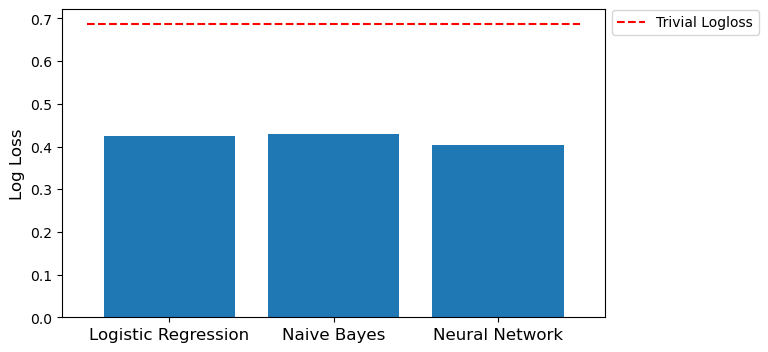

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
model_list = [d_logr, d_nbayes, d_nn]
model_names = [model['name'] for model in model_list]
ax.bar([0.5, 1.5, 2.5], [model['test_loss'] for model in model_list])
# ax.set_title('Model Logloss Comparison', fontsize=16)
ax.set_ylabel('Log Loss', fontsize=12)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(model_names, fontsize=12)
ax.plot(np.arange(0, 4), np.ones(4) * trivial_logloss, 'r--', label='Trivial Logloss')
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.02));


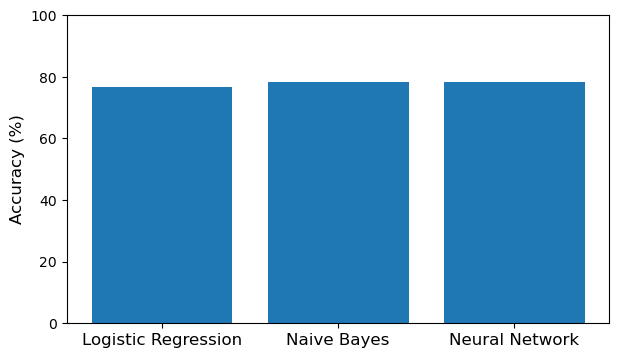

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.bar([0.5, 1.5, 2.5], [model['test_acc'] for model in model_list])
# ax.set_title('Model Accuracy Comparison', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(model_names, fontsize=12)
ax.set_ylim([0, 100]);


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_56511/2063174362.py:51: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


The calibration RMSE for the Logistic Regression model (weighted by bin counts) is 5.337
The calibration RMSE for the Naive Bayes model (weighted by bin counts) is 4.842
The calibration RMSE for the Neural Network model (weighted by bin counts) is 0.971


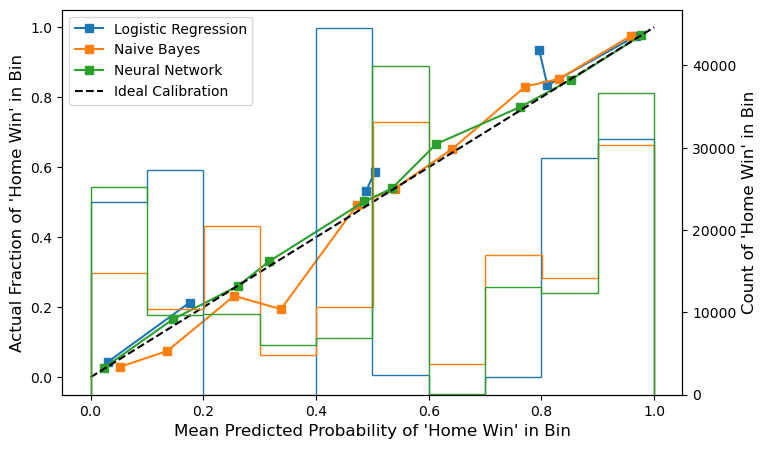

In [55]:
# Check the calibration of each model
model_preds = [model['y_pred'] for model in model_list]
fig, ax, ax2 = plot_calibration_curves(model_list, model_preds, [y_test] * len(model_list), model_names, class1='Home Win')


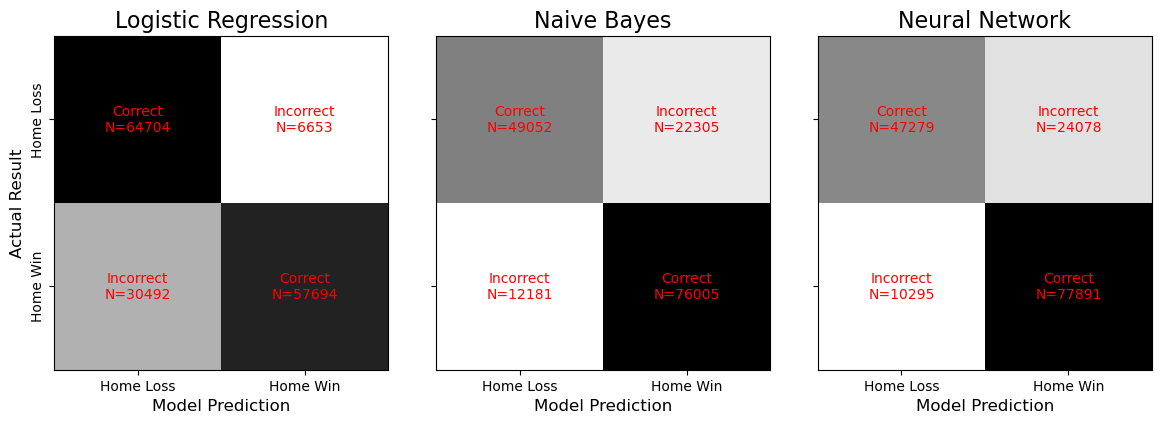

In [56]:
# Plot confusion matrices
fig, axes = plt.subplots(1, len(model_list), figsize=(12, 4), sharey=True)
for i, model in enumerate(model_list):
    conf_mat = confusion_matrix(y_test, np.round(model['y_pred'], 0))
    axes[i].imshow(conf_mat, cmap='Greys')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Home Loss', 'Home Win'])
    axes[i].set_xlabel('Model Prediction', fontsize=12)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['Home Loss', 'Home Win'], va='center', rotation='vertical')
    axes[0].set_ylabel('Actual Result', fontsize=12)
    axes[i].text(0, 0, f'Correct\nN={conf_mat[0, 0]}', c='r', ha='center', va='center')
    axes[i].text(1, 0, f'Incorrect\nN={conf_mat[0, 1]}', c='r', ha='center', va='center')
    axes[i].text(0, 1, f'Incorrect\nN={conf_mat[1, 0]}', c='r', ha='center', va='center')
    axes[i].text(1, 1, f'Correct\nN={conf_mat[1, 1]}', c='r', ha='center', va='center')
    axes[i].set_title(model['name'], fontsize=16)
fig.tight_layout();


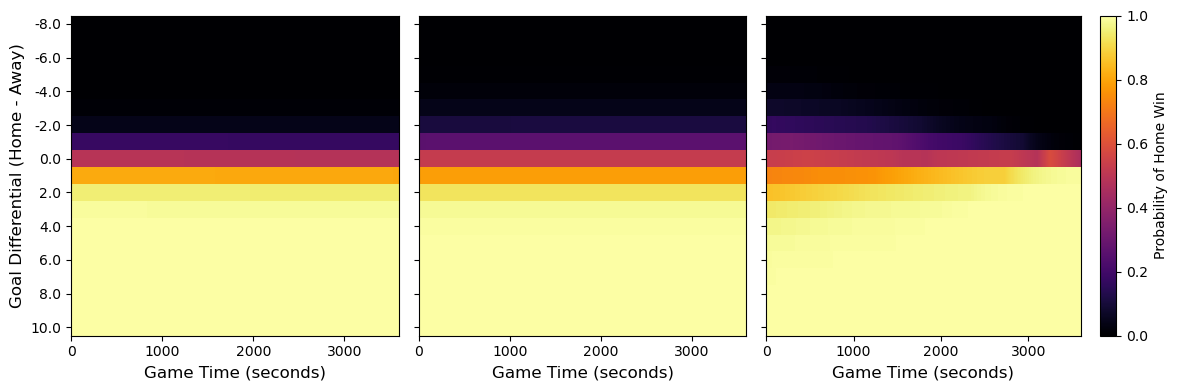

In [57]:
# Calculate the win probability across all game times and goal differentials
goal_diff_range = np.arange(np.floor(data_df.goal_diff.min()), np.ceil(data_df.goal_diff.max() + 1))
game_secs = 20 * 3 * 60
model_probs = np.zeros((len(model_list), goal_diff_range.size, game_secs))
for i, model in enumerate(model_list):
    for j, g_diff in enumerate(goal_diff_range):
        for sec in range(game_secs):
            # input_arr = x_scaler.transform(np.array([g_diff, 0, sec]).reshape(1, -1))
            input_arr = x_scaler.transform(np.array([g_diff, 0, 3600 - sec]).reshape(1, -1))
            if model['name'] == 'Neural Network':
                model_probs[i, j, sec] = sigmoid(model['model'](Tensor(input_arr))).detach().numpy().squeeze()
            else:
                model_probs[i, j, sec] = model['model'].predict_proba(input_arr).squeeze()[1]

# Plot the distributions
fig, axes = plt.subplots(1, len(model_list), figsize=(12, 4), sharey=True,
                         gridspec_kw={'width_ratios':[1, 1, 1.2]})
for i, model in enumerate(model_list):
    p1 = axes[i].imshow(model_probs[i, :, :], cmap='inferno', aspect='auto', interpolation='none', vmin=0, vmax=1)
    axes[i].set_xlabel('Game Time (seconds)', fontsize=12)
cbar = fig.colorbar(p1, ax=axes[-1], orientation='vertical')
cbar.set_label('Probability of Home Win', fontsize=10)
axes[0].set_ylabel('Goal Differential (Home - Away)', fontsize=12)
axes[0].set_yticks(np.arange(goal_diff_range.size)[::2])
axes[0].set_yticklabels(goal_diff_range[::2])
fig.tight_layout();


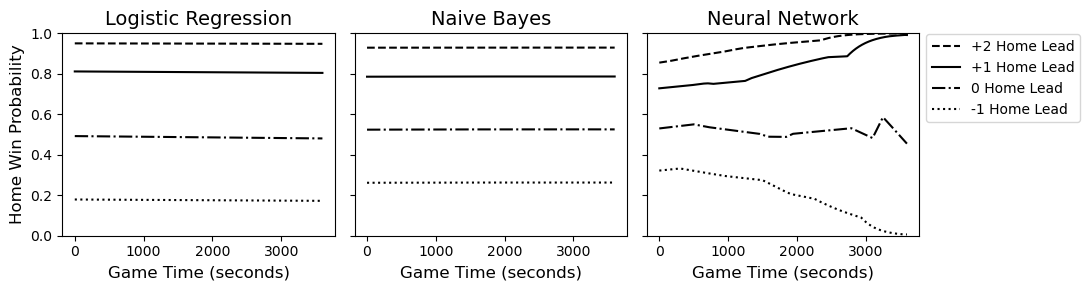

In [58]:
# Plot the continuous win probability for a goal differential of +2, +1, 0 and -1
goal_diffs = [2, 1, 0, -1]
line_stys = ['--', '-', '-.', ':']
fig, axes = plt.subplots(1, len(model_list), figsize=(11, 3), sharey=True)
for i, model in enumerate(model_list):
    for j, goal_diff in enumerate(goal_diffs):
        goal_ind = np.argwhere(goal_diff_range == goal_diff).squeeze()
        lbl = f'+{goal_diff}' if goal_diff > 0 else goal_diff
        axes[i].plot(np.arange(game_secs), model_probs[i, goal_ind, :], f'k{line_stys[j]}', label=f'{lbl} Home Lead')
        axes[i].set_title(model['name'], fontsize=14)
        axes[i].set_xlabel('Game Time (seconds)', fontsize=12)
axes[0].set_ylabel('Home Win Probability', fontsize=12)
axes[-1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.03))
axes[0].set_ylim([0, 1])
fig.tight_layout()


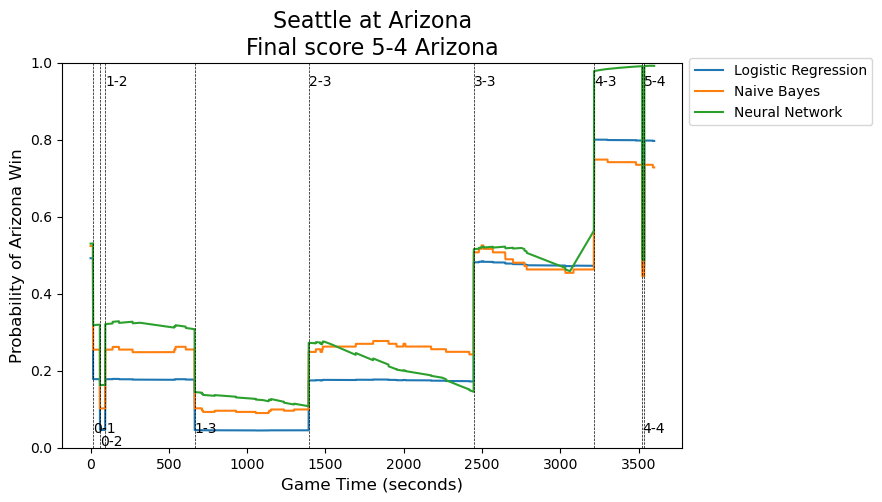

In [59]:
# Plot model predictions as a function of game time

# Extract the shot data for the test game
# https://www.nhl.com/gamecenter/sea-vs-ari/2021/11/06/2021020172#game=2021020172,game_state=final
# https://www.nhl.com/gamecenter/nyr-vs-edm/2021/11/05/2021020158#game=2021020158,game_state=final
# https://www.nhl.com/gamecenter/nsh-vs-tbl/2021/01/30/2020020129#game=2020020129,game_state=final
test_game_id = 2021020172
if test_game_id == 2021020172:
    team_names = ['Arizona', 'Seattle']
elif test_game_id == 2021020158:
    team_names = ['Edmonton', 'New York']
elif test_game_id == 2020020129:
    team_names = ['Tampa Bay', 'Nashville']
test_home_win = games[test_game_id]['home_win']
test_game_shots = shots_df.loc[shots_df.game_id == test_game_id]
plot_in_game_probs(test_game_shots, test_home_win, team_names, [x_scaler] * len(model_list), model_list, names=model_names);


## Comparison of Neural Networks

Finally, as mentioned in the data exploration, the only feature that correlates with the target variable is goal differential. Therefore, it makes to check whether a simpler model, which neglects shot differential, can perform similarly.

The model without shots performs slightly better in terms of logloss and accuracy, however, this may simply be due to the distributions of shots vs. goals. Therefore, it is difficult to draw any conclusions from this. Additionally, the prediction probability distributions and calibration curves are qualitatively similar.

Where we see a difference is in predicting the second-by-second probability during the game. The "goals only" model follows the same path as the "goals + shots" model early in the game, but does not appear to weight late goals as heavily. This is similar to the response of the Naive Bayes and Logistic Regression models. When comparing to existing betting models, late-game leads are weighted heavily, much like the "goals + shots" model. Therefore, this model will be the one chosen to move forward with.


In [30]:
data_df_goals = data_df.drop(columns='shot_diff')
data_df_goals.drop(shots_df[shots_df.shot_result == 'SHOT'].index.tolist(), inplace=True)
data_df_goals.reset_index(drop=True, inplace=True)


In [31]:
# Split the data into training and test sets
X_pd, y_pd = data_df_goals.iloc[:, :-1].values, data_df_goals.iloc[:, -1].values
tmp_split = train_test_split(X_pd, y_pd, test_size=0.25, random_state=66)
X_train, X_test, y_train_goals, y_test_goals = tmp_split

# Scale the data
x_scaler_goals = MinMaxScaler()
X_train_goals = x_scaler_goals.fit_transform(X_train)
X_test_goals = x_scaler_goals.transform(X_test)


In [32]:
# Define the training and test data loaders
train_data_goals = CustomDataset(X_train_goals, y_train_goals)
test_data_goals = CustomDataset(X_test_goals, y_test_goals)
train_dataloader_goals = DataLoader(train_data_goals, batch_size=batch_size, shuffle=False)
test_dataloader_goals = DataLoader(test_data_goals, batch_size=batch_size, shuffle=False)

# Initialize a model and optimizer
d_nn_goals = {'name': 'Neural Network (Goals Only)',
              'model': RegressionNN(X_train_goals.shape[-1], 32, 1).to('cpu').float(),
              'type': 'NN'}
# optimizer = optim.SGD(d_nn['model'].parameters(), lr=learning_rate)
optimizer = optim.Adam(d_nn_goals['model'].parameters(), lr=learning_rate)


Took 0:00:16.690657 to train the model


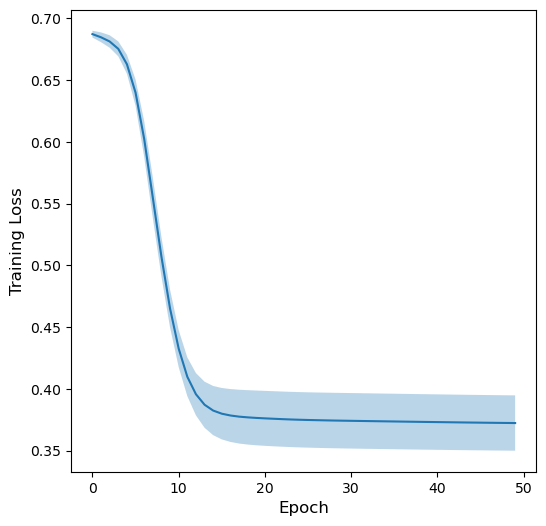

In [33]:
# Train the model
train_loss_avg = np.zeros(n_epochs)
train_loss_std = np.zeros(n_epochs)
t_start = time()
for t in range(n_epochs):
    epoch_loss = train_loop(train_dataloader_goals, d_nn_goals['model'], loss_fn, optimizer)
    train_loss_avg[t] = np.mean(epoch_loss)
    train_loss_std[t] = np.std(epoch_loss)

# Plot the progression of loss and accuracy
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.arange(n_epochs), train_loss_avg)
ax.fill_between(np.arange(n_epochs), train_loss_avg - train_loss_std, train_loss_avg + train_loss_std, alpha=0.3)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Training Loss', fontsize=12)

# Print the time taken
t_full = time() - t_start
print(f'Took {timedelta(seconds=t_full)} to train the model')
plt.show()


Trivial logloss for this problem: 0.687
Training logloss on NN (no shots) model: 0.372
Test logloss on NN (no shots) model: 0.367
Test accuracy on NN (no shots) model: 83.17%


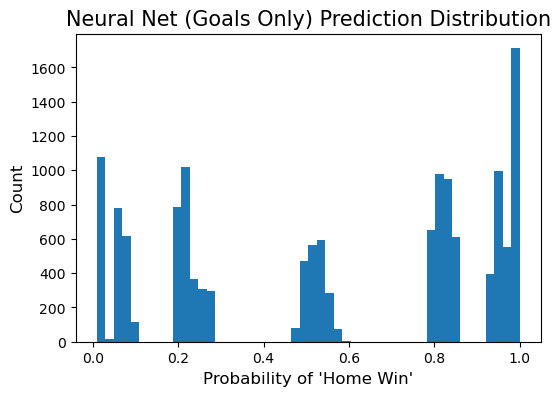

In [34]:
# Test the model
y_pred_train_nn = sigmoid(d_nn_goals['model'](Tensor(X_train_goals))).detach().numpy().squeeze()
d_nn_goals['train_loss'] = log_loss(y_train_goals, y_pred_train_nn)
d_nn_goals['y_pred'] = sigmoid(d_nn_goals['model'](Tensor(X_test_goals))).detach().numpy().squeeze()
d_nn_goals['test_loss'] = log_loss(y_test_goals, d_nn_goals['y_pred'])
print(f"Trivial logloss for this problem: {trivial_logloss:4.3f}")
print(f"Training logloss on NN (no shots) model: {d_nn_goals['train_loss']:4.3f}")
print(f"Test logloss on NN (no shots) model: {d_nn_goals['test_loss']:4.3f}")
pred_classes = np.round(d_nn_goals['y_pred'], 0)
d_nn_goals['test_acc'] = (pred_classes == y_test_goals).sum() / y_test_goals.size
print(f"Test accuracy on NN (no shots) model: {100 * d_nn_goals['test_acc']:4.2f}%")

# Plot the prediction distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(d_nn_goals['y_pred'], bins=50)
ax.set_title('Neural Net (Goals Only) Prediction Distribution', fontsize=15)
ax.set_xlabel("Probability of 'Home Win'", fontsize=12)
ax.set_ylabel('Count', fontsize=12);


The calibration RMSE for the Neural Network model (weighted by bin counts) is 1.234
The calibration RMSE for the Neural Network (Goals Only) model (weighted by bin counts) is 0.844


/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/marshineer/anaconda3/envs/hockey/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_56511/2063174362.py:51: RuntimeWarning: invalid value encountered in long_scalars
  true_frac[j] = (y_true_bin == 1).sum() / y_true_bin.size


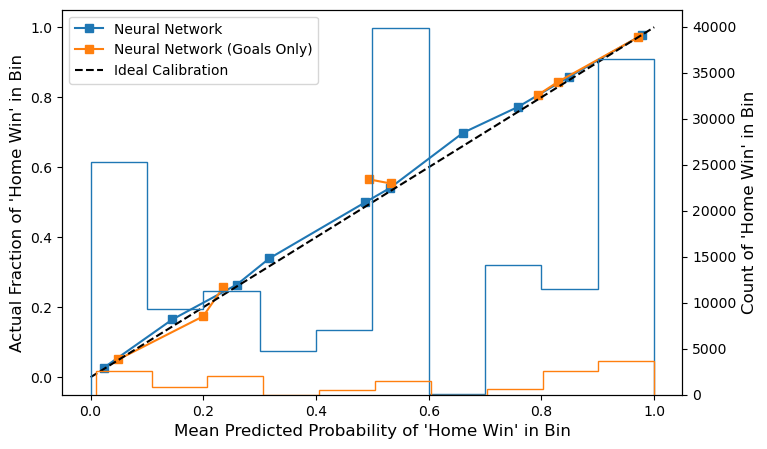

In [35]:
# Check the calibration of each model
nn_list = [d_nn, d_nn_goals]
nn_preds = [model['y_pred'] for model in nn_list]
nn_ys = [y_test, y_test_goals]
nn_names = [model['name'] for model in nn_list]
fig, ax, ax2 = plot_calibration_curves(nn_list, nn_preds, nn_ys, nn_names, class1='Home Win')


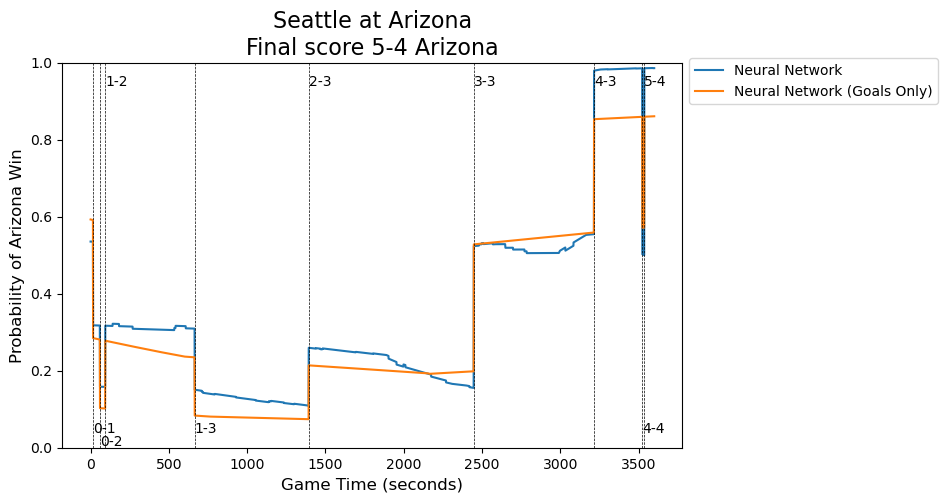

In [36]:
# Plot the single game example
x_scaler_list = [x_scaler, x_scaler_goals]
plot_in_game_probs(test_game_shots, test_home_win, team_names, x_scaler_list, nn_list, names=nn_names);
